In [1]:
import os
import time
import re
from glob import glob
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

import tensorflow as tf
from PIL import Image

print("Tensorflow: v{}".format(tf.__version__))
%matplotlib inline

Tensorflow: v2.14.0


In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
# Function to load and preprocess images from CIFAR-10

def load_cifar_batch(file_path):
    data_dict = unpickle(file_path)
    images = data_dict[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    labels = np.array(data_dict[b'labels'])  # Convert labels to NumPy array
    return images, labels

In [4]:
# Function to load and preprocess CIFAR-10 dataset
        
def load_cifar_dataset(dataset_path):
    images, labels = [], []
    for i in range(1, 6): # Load data_batch_1 to data_batch_5
        batch_path = os.path.join(dataset_path, f'data_batch_{i}')
        batch_images, batch_labels = load_cifar_batch(batch_path)
        images.append(batch_images)
        labels.append(batch_labels)

    test_batch_path = os.path.join(dataset_path, 'test_batch')
    test_images, test_labels = load_cifar_batch(test_batch_path)

    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)

    print("Debug: Inside load_cifar_dataset")
    print("Debug: Images Shape:", images.shape)
    print("Debug: Labels Shape:", labels.shape)
    print("Debug: Test Images Shape:", test_images.shape)
    print("Debug: Test Labels Shape:", test_labels.shape)

    return images, labels, test_images, test_labels


In [7]:
file_path = './cifar-10-python/cifar-10-batches-py'
train_images, train_labels, test_images, test_labels = load_cifar_dataset(file_path)

# Now you can use the loaded variables in the rest of your script
print("Train Images Shape:", train_images.shape)
print("Train Labels Shape:", train_labels.shape)
print("Test Images Shape:", test_images.shape)
print("Test Labels Shape:", test_labels.shape)

Debug: Inside load_cifar_dataset
Debug: Images Shape: (50000, 32, 32, 3)
Debug: Labels Shape: (50000,)
Debug: Test Images Shape: (10000, 32, 32, 3)
Debug: Test Labels Shape: (10000,)
Train Images Shape: (50000, 32, 32, 3)
Train Labels Shape: (50000,)
Test Images Shape: (10000, 32, 32, 3)
Test Labels Shape: (10000,)


In [8]:
def preprocess_cifar_image(image, label):
    # Convert to tf.float32
    image = tf.cast(image, tf.float32)
    # Normalize pixel values to be between 0 and 1
    image = image / 255.0
    return image, label

In [9]:
# Create TensorFlow Datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.map(preprocess_cifar_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=50000).batch(64).repeat()

test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_ds = test_ds.map(preprocess_cifar_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.batch(64).repeat()


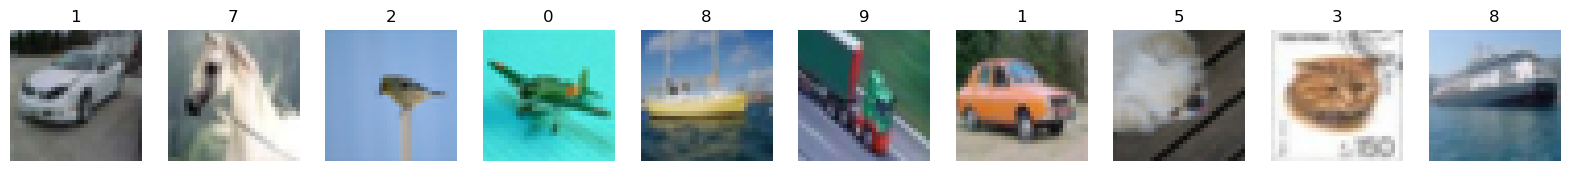

In [10]:
# Visualize a batch of CIFAR-10 training images
for images, labels in train_ds.take(1):
    fig, ax = plt.subplots(1, 10, figsize=(20, 2))
    for j in range(10):
        ax[j].imshow(images[j].numpy())
        ax[j].set_title(labels[j].numpy())
        ax[j].axis('off')
    plt.show()

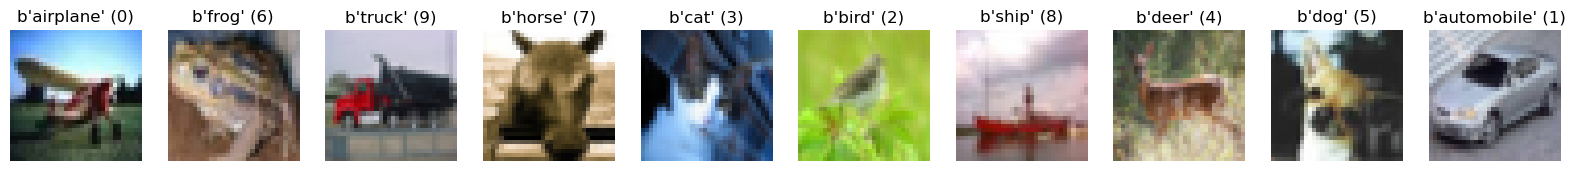

In [11]:
# Load label names
label_names_path = os.path.join(file_path, 'batches.meta')
label_names_dict = unpickle(label_names_path)
label_names = label_names_dict[b'label_names']

# Visualize a batch of CIFAR-10 training images with class names
unique_labels = set()
for images, labels in train_ds.take(1):
    fig, ax = plt.subplots(1, 10, figsize=(20, 2))
    idx = 0
    for j in range(len(labels)):
        class_name = label_names[labels[j].numpy()]
        if class_name not in unique_labels:
            ax[idx].imshow(images[j].numpy())
            ax[idx].set_title(f"{class_name} ({labels[j].numpy()})")
            ax[idx].axis('off')
            unique_labels.add(class_name)
            idx += 1
            if idx == 10:
                break
    plt.show()



Label Meanings:
0: b'airplane'
1: b'automobile'
2: b'bird'
3: b'cat'
4: b'deer'
5: b'dog'
6: b'frog'
7: b'horse'
8: b'ship'
9: b'truck'


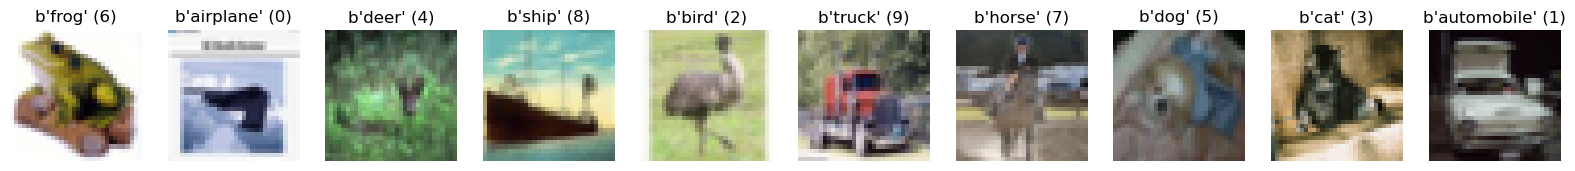

In [12]:
# Visualize a batch of CIFAR-10 training images with class names and print label meanings
unique_labels = set()
for images, labels in train_ds.take(1):
    fig, ax = plt.subplots(1, 10, figsize=(20, 2))
    idx = 0
    for j in range(len(labels)):
        class_name = label_names[labels[j].numpy()]
        if class_name not in unique_labels:
            ax[idx].imshow(images[j].numpy())
            ax[idx].set_title(f"{class_name} ({labels[j].numpy()})")
            ax[idx].axis('off')
            unique_labels.add(class_name)
            idx += 1
            if idx == 10:
                break

# Print label meanings
print("Label Meanings:")
for i, class_name in enumerate(label_names):
    print(f"{i}: {class_name}")
plt.show()


In [13]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [14]:
class Conv(tf.keras.Model):
    def __init__(self, filters, kernel_size, strides=(1, 1), pool_size=None):
        super(Conv, self).__init__()
        
        self.conv = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides)
        self.bn = tf.keras.layers.BatchNormalization()
        
        self.relu = tf.keras.layers.ReLU()
        self.pool = None
        
        if pool_size:
            self.pool = tf.keras.layers.MaxPool2D(pool_size=pool_size)
        
    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = self.relu(x)
        
        if self.pool:
            x = self.pool(x)
            
        return x


In [15]:
file_path = './cifar-10-python/cifar-10-batches-py'
train_images, train_labels, test_images, test_labels = load_cifar_dataset(file_path)


Debug: Inside load_cifar_dataset
Debug: Images Shape: (50000, 32, 32, 3)
Debug: Labels Shape: (50000,)
Debug: Test Images Shape: (10000, 32, 32, 3)
Debug: Test Labels Shape: (10000,)


In [16]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPool2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Build the model
model = tf.keras.Sequential(name='CIFAR-10_CNN')
model.add(Conv(filters=32, kernel_size=(3, 3)))
model.add(Conv(filters=64, kernel_size=(3, 3)))
model.add(Conv(filters=128, kernel_size=(3, 3), pool_size=(3, 3)))
model.add(Conv(filters=128, kernel_size=(3, 3), strides=(2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=512, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax))  # 10 classes in CIFAR-10

In [17]:
model(images[:1])

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.00492892, 0.1097441 , 0.11385061, 0.18970238, 0.11000571,
        0.04742553, 0.04913056, 0.01545983, 0.14665619, 0.21309614]],
      dtype=float32)>

In [18]:
# Model checkpoint
checkpoint_path = "./cifar-10-python/cifar-10-batches-py/cifar_10_cnn/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)


In [19]:
# Compile the model

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "CIFAR-10_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv (Conv)                 (1, 30, 30, 32)           1024      
                                                                 
 conv_1 (Conv)               (1, 28, 28, 64)           18752     
                                                                 
 conv_2 (Conv)               (1, 8, 8, 128)            74368     
                                                                 
 conv_3 (Conv)               (1, 3, 3, 128)            148096    
                                                                 
 flatten (Flatten)           (1, 1152)                 0         
                                                                 
 dense (Dense)               (1, 512)                  590336    
                                                                 
 dense_1 (Dense)             (1, 10)                  

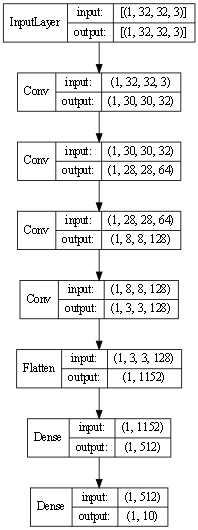

In [20]:
plot_model(model, show_shapes=True, show_layer_names=False, dpi=60)


In [21]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Calculate the length of the training and test sets
train_len = len(train_images)
test_len = len(test_images)

print("Length of the CIFAR-10 training set:", train_len)
print("Length of the CIFAR-10 test set:", test_len)


Length of the CIFAR-10 training set: 50000
Length of the CIFAR-10 test set: 10000


In [22]:
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0
history = model.fit(train_images, train_labels, epochs=40,
          validation_data=(test_images, test_labels),
          callbacks=[cp_callback])

Epoch 1/40
1563/1563 [==============================] - ETA: 0s - loss: 1.8615 - accuracy: 0.3302
Epoch 1: val_loss improved from inf to 1.62221, saving model to ./cifar-10-python/cifar-10-batches-py/cifar_10_cnn\cp-0001.ckpt
1563/1563 [==============================] - 248s 157ms/step - loss: 1.8615 - accuracy: 0.3302 - val_loss: 1.6222 - val_accuracy: 0.4200
Epoch 2/40
1563/1563 [==============================] - ETA: 0s - loss: 1.5264 - accuracy: 0.4557
Epoch 2: val_loss improved from 1.62221 to 1.45235, saving model to ./cifar-10-python/cifar-10-batches-py/cifar_10_cnn\cp-0002.ckpt
1563/1563 [==============================] - 259s 166ms/step - loss: 1.5264 - accuracy: 0.4557 - val_loss: 1.4523 - val_accuracy: 0.4805
Epoch 3/40
1563/1563 [==============================] - ETA: 0s - loss: 1.3793 - accuracy: 0.5137
Epoch 3: val_loss improved from 1.45235 to 1.35491, saving model to ./cifar-10-python/cifar-10-batches-py/cifar_10_cnn\cp-0003.ckpt
1563/1563 [=============================

Epoch 24/40
1563/1563 [==============================] - ETA: 0s - loss: 0.6436 - accuracy: 0.7879
Epoch 24: val_loss did not improve from 0.98607
1563/1563 [==============================] - 233s 149ms/step - loss: 0.6436 - accuracy: 0.7879 - val_loss: 0.9926 - val_accuracy: 0.6643
Epoch 25/40
1563/1563 [==============================] - ETA: 0s - loss: 0.6271 - accuracy: 0.7935
Epoch 25: val_loss did not improve from 0.98607
1563/1563 [==============================] - 240s 154ms/step - loss: 0.6271 - accuracy: 0.7935 - val_loss: 0.9893 - val_accuracy: 0.6625
Epoch 26/40
1563/1563 [==============================] - ETA: 0s - loss: 0.6116 - accuracy: 0.8003
Epoch 26: val_loss improved from 0.98607 to 0.98285, saving model to ./cifar-10-python/cifar-10-batches-py/cifar_10_cnn\cp-0026.ckpt
1563/1563 [==============================] - 232s 148ms/step - loss: 0.6116 - accuracy: 0.8003 - val_loss: 0.9829 - val_accuracy: 0.6683
Epoch 27/40
1563/1563 [==============================] - ETA: 0

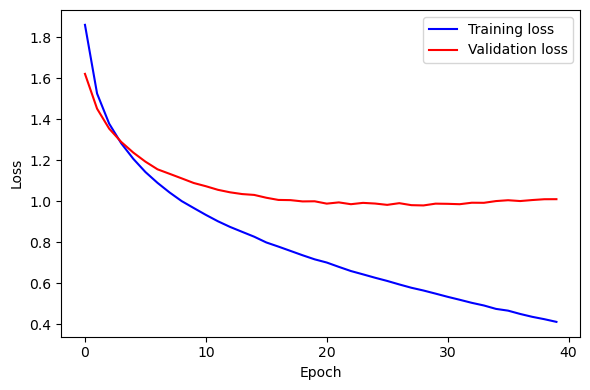

In [23]:
epochs=40


def plot_loss(history, epochs):
    fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
    ax1.plot(history.history['loss'], color='b', label="Training loss")
    ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
    ax1.set_xticks(np.arange(0, epochs + 1, 10))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    plt.tight_layout()
    plt.show()

# Assuming you have 'epochs' defined
plot_loss(history, epochs)

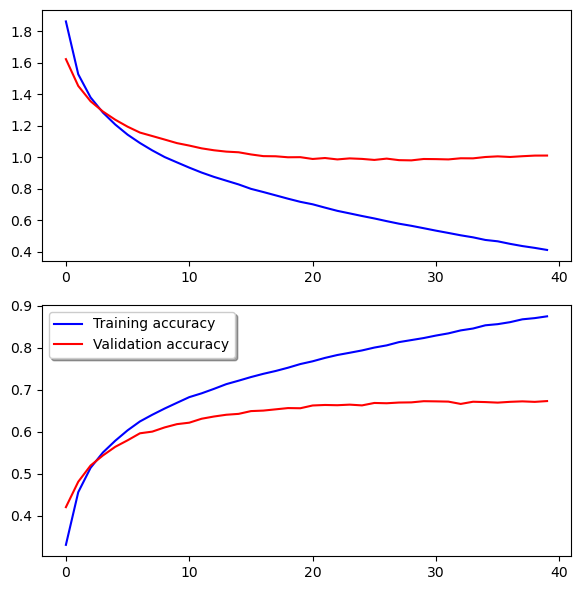

In [24]:
epochs=40

def plot_loss(history):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))
    ax1.plot(history.history['loss'], color='b', label="Training loss")
    ax1.plot(history.history['val_loss'], color='r', label="validation loss")
    ax1.set_xticks(np.arange(0, epochs + 1, 10))
    
    ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
    ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    ax2.set_xticks(np.arange(0, epochs+1, 10))

    legend = plt.legend(loc='best', shadow=True)
    plt.tight_layout()
    plt.show()
plot_loss(history)

In [25]:
model.save("cifar10.keras")

In [27]:
model.evaluate(test_ds, steps=test_len / 64)


156/156 [==============================] - 8s 49ms/step - loss: 1.0106 - accuracy: 0.6728


[1.0105667114257812, 0.6728000044822693]

In [28]:
model_inf = tf.keras.Sequential(name='CIFAR-10_CNN_load')
model_inf.add(Conv(filters=32, kernel_size=(3, 3)))
model_inf.add(Conv(filters=64, kernel_size=(3, 3)))
model_inf.add(Conv(filters=128, kernel_size=(3, 3), pool_size=(3, 3)))
model_inf.add(Conv(filters=128, kernel_size=(3, 3), strides=(2, 2)))
model_inf.add(tf.keras.layers.Flatten())
model_inf.add(tf.keras.layers.Dense(units=512, activation=tf.keras.activations.relu))
model_inf.add(tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax))  # 10 classes in CIFAR-10

model_inf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


for images, labels in train_ds.take(1):
    outputs = model_inf(images, training=False)
    
# Load model
model_inf.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

In [29]:
model_inf.evaluate(test_ds, steps=test_len / 64)


156/156 [==============================] - 8s 51ms/step - loss: 0.9800 - accuracy: 0.6697


[0.9800316691398621, 0.669700026512146]

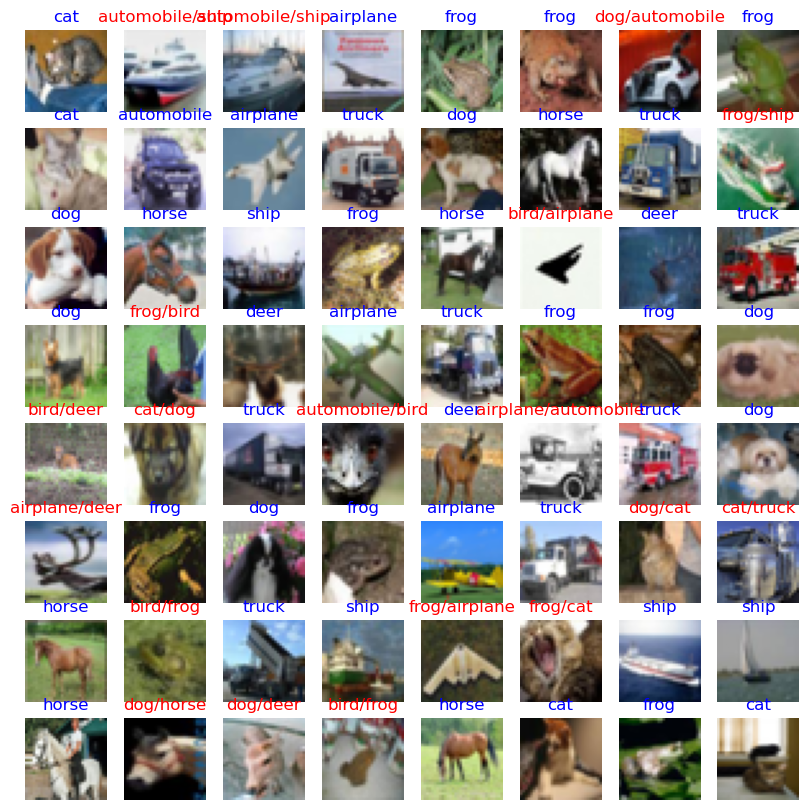

In [33]:
test_batch_size = 64

# Define the class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for images, labels in test_ds.take(1):
    predictions = model_inf(images)

images = images[:test_batch_size]
labels = labels[:test_batch_size]
predictions = predictions[:test_batch_size]

# 시각화
fig = plt.figure(figsize=(10, 10))
for i, (px, py, y_pred) in enumerate(zip(images, labels, predictions)):
    p = fig.add_subplot(8, 8, i+1)
    if np.argmax(y_pred.numpy()) == py.numpy():
        p.set_title("{}".format(class_names[py.numpy()]), color='blue')
    else:
        p.set_title("{}/{}".format(class_names[np.argmax(y_pred.numpy())], class_names[py.numpy()]), color='red')
    p.imshow(px.numpy())
    p.axis('off')

plt.show()